# Grain Body vs Grain Boundary — Mean Comparison

This notebook loads `stats_with_light_condition.csv`, aggregates measurements for labels 1 (grain body) and 2 (grain boundary),
groups by `temperature` and `percentage`, and plots mean values with standard-deviation error bars.

It also includes a plot of the difference (Grain Body mean - Grain Boundary mean) arranged as a grid by light condition (rows) and percentage (columns).

In [1]:
# Imports and paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path('stats_with_light_condition.csv')
OUT_DIR = Path('plots')
OUT_DIR.mkdir(exist_ok=True)

print('CSV path:', CSV_PATH.resolve())
print('Output dir:', OUT_DIR.resolve())

CSV path: C:\Users\david\Dropbox\random_forest_gui\stats_with_light_condition.csv
Output dir: C:\Users\david\Dropbox\random_forest_gui\plots


In [2]:
# Load and clean data
df = pd.read_csv(CSV_PATH)
# normalize light condition text
df['light_condition'] = df['light_condition'].astype(str).str.strip().str.rstrip('.')
# ensure numeric columns
for c in ['temperature','percentage','mean','std','count']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print('Loaded', df.shape, 'rows')
df.head()

Loaded (22, 13) rows


,file,label,temperature,percentage,count,mean,std,median,p25,p75,min,max,light_condition
0,CdTe_0per_350C_2.gwy,1,350,0,8839,0.000123,0.000016,0.000123,0.000112,0.000134,0.000059,0.000181,ON
1,CdTe_0per_350C_2.gwy,2,350,0,5561,0.000142,0.000016,0.000141,0.000131,0.000152,0.000021,0.000198,ON
2,CdTe_0per_350C_3.gwy,1,350,0,6873,-0.000046,0.000018,-0.000047,-0.000058,-0.000034,-0.000112,0.000016,OFF
3,CdTe_0per_350C_3.gwy,2,350,0,7527,-0.000027,0.000018,-0.000027,-0.000039,-0.000015,-0.000084,0.000034,OFF
4,CdTe_0per_350C_4.gwy,1,350,0,9296,-0.000103,0.000026,-0.000103,-0.000120,-0.000085,-0.000240,-0.000010,OFF


In [3]:
# Aggregate by temperature, percentage, light_condition and label
agg = (
    df[df['label'].isin([1,2])]
    .groupby(['temperature','percentage','light_condition','label'])
    .agg(mean_of_mean=('mean','mean'), std_of_mean=('mean','std'), mean_std=('std','mean'), count_sum=('count','sum'))
    .reset_index()
)
# replace NaN std (single-sample groups) with 0
agg['std_of_mean'] = agg['std_of_mean'].fillna(0.0)

print('Aggregated shape:', agg.shape)
agg.head()

Aggregated shape: (16, 8)


,temperature,percentage,light_condition,label,mean_of_mean,std_of_mean,mean_std,count_sum
0,350,0,OFF,1,-0.000074,4.004903e-05,0.000022,16169
1,350,0,OFF,2,-0.000049,3.184766e-05,0.000020,12631
2,350,0,ON,1,0.000123,0.000000e+00,0.000016,8839
3,350,0,ON,2,0.000142,0.000000e+00,0.000016,5561
4,350,7,OFF,1,-0.000102,9.659407e-07,0.000017,20719


Saved: C:\Users\david\Dropbox\random_forest_gui\plots\mean_comparison_grid.png


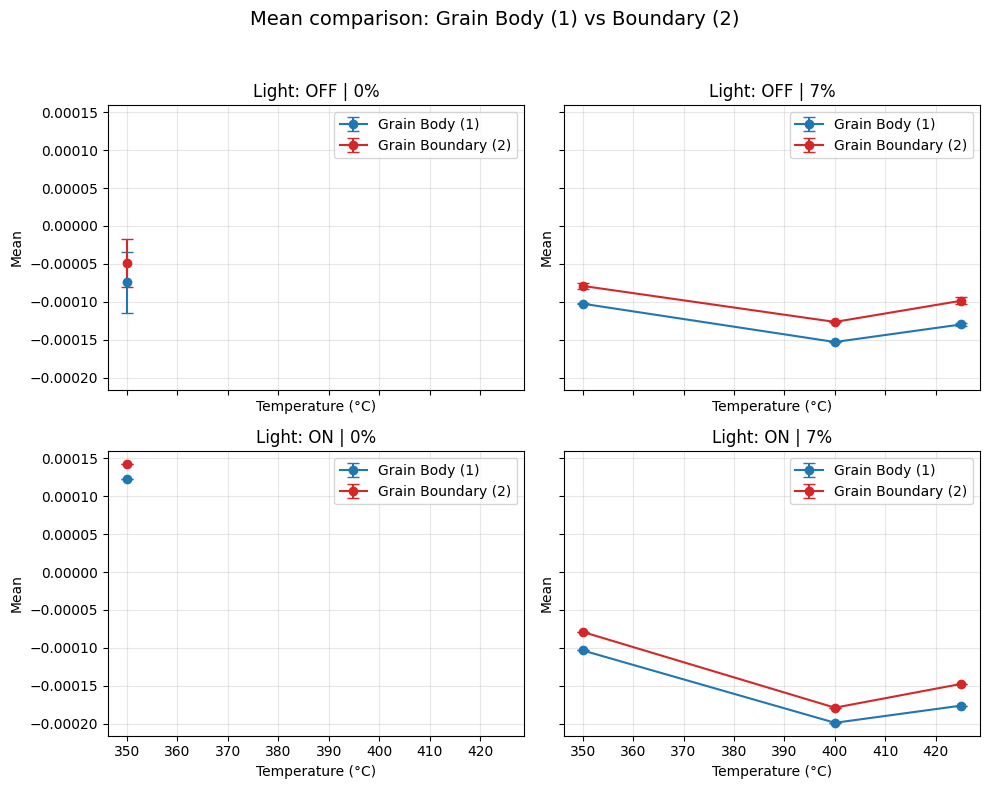

In [4]:
# Plot mean values with std error bars in a grid (rows=light_condition, cols=percentage)
lights = sorted(agg['light_condition'].dropna().unique())
percentages = sorted(agg['percentage'].dropna().unique())

nrows = max(1, len(lights))
ncols = max(1, len(percentages))

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

for i, light in enumerate(lights):
    for j, pct in enumerate(percentages):
        ax = axes[i, j]
        sub = agg[(agg['light_condition'] == light) & (agg['percentage'] == pct)]
        if sub.empty:
            ax.set_title(f'Light: {light} | {int(pct)}%\n(no data)')
            ax.set_xlabel('Temperature (°C)')
            ax.set_ylabel('Mean')
            continue
        # plot each label on same axes
        for label, color, name in [(1,'tab:blue','Grain Body (1)'), (2,'tab:red','Grain Boundary (2)')]:
            dat = sub[sub['label'] == label].sort_values('temperature')
            if dat.empty:
                continue
            x = dat['temperature'].values
            y = dat['mean_of_mean'].values
            yerr = dat['std_of_mean'].values
            ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', color=color, label=name, capsize=4)
        ax.set_title(f'Light: {light} | {int(pct)}%')
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel('Mean')
        ax.legend()
        ax.grid(alpha=0.3)

# hide unused axes
total = nrows * ncols
used = len(lights) * len(percentages)
if total > used:
    flat = axes.flatten()
    for k in range(used, total):
        flat[k].set_visible(False)

fig.suptitle('Mean comparison: Grain Body (1) vs Boundary (2)', fontsize=14)
fig.tight_layout(rect=[0,0,1,0.95])
outp = OUT_DIR / 'mean_comparison_grid.png'
fig.savefig(outp, dpi=200)
print('Saved:', outp.resolve())
plt.show()

Saved: C:\Users\david\Dropbox\random_forest_gui\plots\diff_means_grid.png


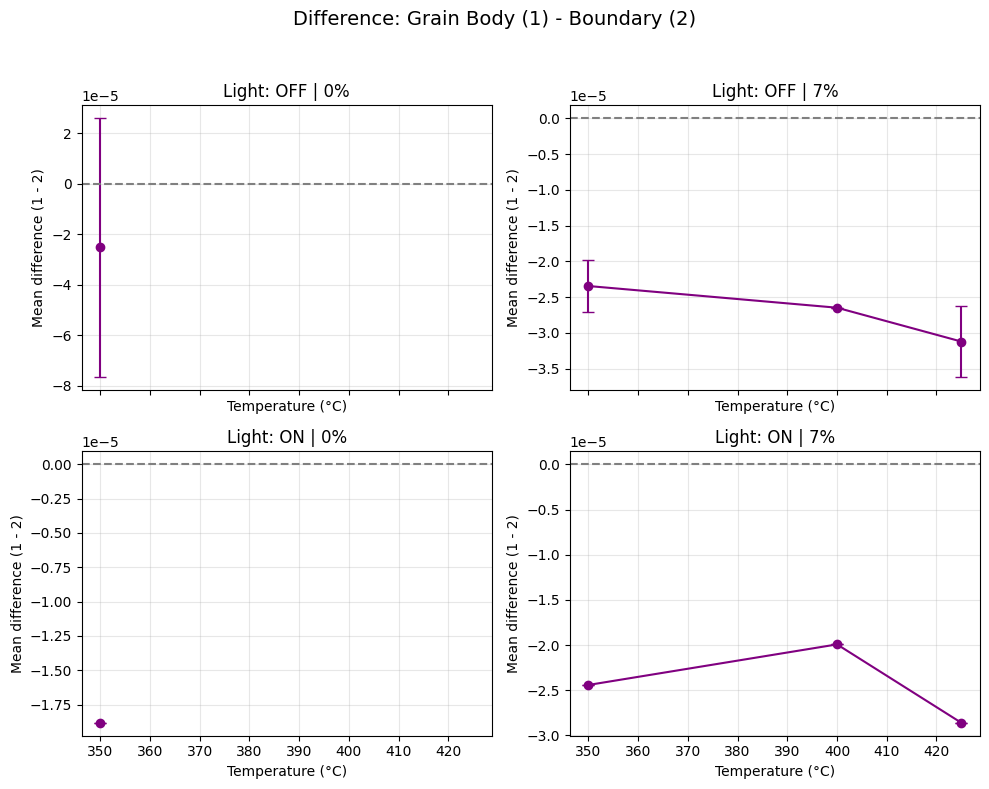

In [5]:
# Plot difference (Grain Body mean - Grain Boundary mean) as a grid by light_condition (rows) and percentage (cols)
# First pivot aggregated data so labels are columns
pivot = agg.pivot_table(index=['temperature','percentage','light_condition'], columns='label', values=['mean_of_mean','std_of_mean']).reset_index()
# flatten columns
pivot.columns = [f'{a}_{int(b)}' if b!='' else a for a,b in pivot.columns.tolist()]
# ensure columns exist for both labels (1 and 2)
# compute difference and propagated std
pivot['diff_mean_1_2'] = pivot.get('mean_of_mean_1', np.nan) - pivot.get('mean_of_mean_2', np.nan)
pivot['diff_std'] = np.sqrt(pivot.get('std_of_mean_1', 0).fillna(0)**2 + pivot.get('std_of_mean_2', 0).fillna(0)**2)

# Prepare grid
lights = sorted(pivot['light_condition'].dropna().unique())
percentages = sorted(pivot['percentage'].dropna().unique())
nrows = max(1, len(lights))
ncols = max(1, len(percentages))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols,4*nrows), sharex=True)
axes = np.atleast_2d(axes)
for i, light in enumerate(lights):
    for j, pct in enumerate(percentages):
        ax = axes[i,j]
        d = pivot[(pivot['light_condition']==light) & (pivot['percentage']==pct)].sort_values('temperature')
        if d.empty:
            ax.set_title(f'Light: {light} | {int(pct)}%\n(no data)')
            continue
        ax.errorbar(d['temperature'], d['diff_mean_1_2'], yerr=d['diff_std'], fmt='o-', color='purple', capsize=4)
        ax.axhline(0, color='gray', linestyle='--')
        ax.set_title(f'Light: {light} | {int(pct)}%')
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel('Mean difference (1 - 2)')
        ax.grid(alpha=0.3)

# hide unused axes
total = nrows * ncols
used = len(lights) * len(percentages)
if total > used:
    flat = axes.flatten()
    for k in range(used, total):
        flat[k].set_visible(False)

fig.suptitle('Difference: Grain Body (1) - Boundary (2)', fontsize=14)
fig.tight_layout(rect=[0,0,1,0.95])
outp = OUT_DIR / 'diff_means_grid.png'
fig.savefig(outp, dpi=200)
print('Saved:', outp.resolve())
plt.show()

Notes:
- The notebook groups by `temperature` and `percentage` and compares label 1 vs label 2.
- Error bars show the std across per-file means (std_of_mean).
- If you want weighted means (by `count`) or statistical tests (t-test), I can add a cell to compute and annotate significance.

# Grain Body vs Grain Boundary Comparison

This notebook loads `stats_with_light_condition.csv`, aggregates measurements for labels 1 (grain body) and 2 (grain boundary),
and produces a grid of matplotlib plots with error bars (std) for each combination of light condition (rows) and percentage (columns).
It also computes and plots the difference (label 1 - label 2) for the 7% condition.

In [6]:
# Imports and basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

CSV_PATH = Path('stats_with_light_condition.csv')
OUT_DIR = Path('plots')
OUT_DIR.mkdir(exist_ok=True)

print('CSV:', CSV_PATH.resolve())
print('Output directory:', OUT_DIR.resolve())

CSV: C:\Users\david\Dropbox\random_forest_gui\stats_with_light_condition.csv
Output directory: C:\Users\david\Dropbox\random_forest_gui\plots


In [7]:
# Load data and basic cleaning
df = pd.read_csv(CSV_PATH)
# Normalize light condition strings
df['light_condition'] = df['light_condition'].astype(str).str.strip().str.rstrip('.')
for c in ['temperature','percentage','mean','std','count']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

print('Loaded shape:', df.shape)
df.head()

Loaded shape: (22, 13)


,file,label,temperature,percentage,count,mean,std,median,p25,p75,min,max,light_condition
0,CdTe_0per_350C_2.gwy,1,350,0,8839,0.000123,0.000016,0.000123,0.000112,0.000134,0.000059,0.000181,ON
1,CdTe_0per_350C_2.gwy,2,350,0,5561,0.000142,0.000016,0.000141,0.000131,0.000152,0.000021,0.000198,ON
2,CdTe_0per_350C_3.gwy,1,350,0,6873,-0.000046,0.000018,-0.000047,-0.000058,-0.000034,-0.000112,0.000016,OFF
3,CdTe_0per_350C_3.gwy,2,350,0,7527,-0.000027,0.000018,-0.000027,-0.000039,-0.000015,-0.000084,0.000034,OFF
4,CdTe_0per_350C_4.gwy,1,350,0,9296,-0.000103,0.000026,-0.000103,-0.000120,-0.000085,-0.000240,-0.000010,OFF


In [8]:
# Aggregate data by temperature, percentage, light_condition and label
agg = (
    df[df['label'].isin([1,2])]
    .groupby(['temperature','percentage','light_condition','label'])
    .agg( mean_of_mean=('mean','mean'), std_of_mean=('mean','std'), mean_std=('std','mean'), count_sum=('count','sum') )
    .reset_index()
)
agg['std_of_mean'] = agg['std_of_mean'].fillna(0.0)
print('Aggregated shape:', agg.shape)
agg.head()

Aggregated shape: (16, 8)


,temperature,percentage,light_condition,label,mean_of_mean,std_of_mean,mean_std,count_sum
0,350,0,OFF,1,-0.000074,4.004903e-05,0.000022,16169
1,350,0,OFF,2,-0.000049,3.184766e-05,0.000020,12631
2,350,0,ON,1,0.000123,0.000000e+00,0.000016,8839
3,350,0,ON,2,0.000142,0.000000e+00,0.000016,5561
4,350,7,OFF,1,-0.000102,9.659407e-07,0.000017,20719


Saved figure to: C:\Users\david\Dropbox\random_forest_gui\plots\label_comparison_grid_matplotlib.png


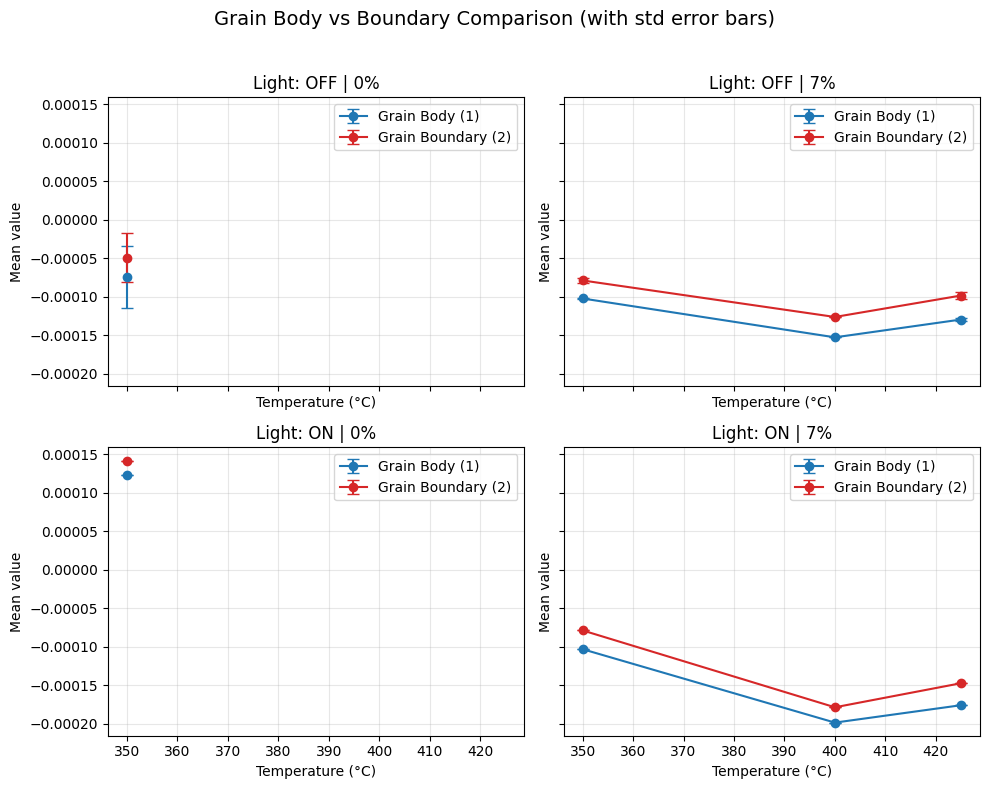

In [9]:
# Plotting grid: rows = light_condition, cols = percentage
lights = sorted(agg['light_condition'].dropna().unique())
percentages = sorted(agg['percentage'].dropna().unique())
nrows = max(1, len(lights))
ncols = max(1, len(percentages))
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True, sharey=True)
axes = np.atleast_2d(axes)
for i, light in enumerate(lights):
    for j, pct in enumerate(percentages):
        ax = axes[i, j]
        subset = agg[(agg['light_condition'] == light) & (agg['percentage'] == pct)]
        if subset.empty:
            ax.set_title("Light: {} | {}%\n(no data)".format(light, int(pct)))
            ax.set_xlabel('Temperature (°C)')
            ax.set_ylabel('Mean value')
            continue
        for label, color, label_name in [(1, 'tab:blue', 'Grain Body (1)'), (2, 'tab:red', 'Grain Boundary (2)')]:
            data = subset[subset['label'] == label].sort_values('temperature')
            if data.empty:
                continue
            x = data['temperature'].values
            y = data['mean_of_mean'].values
            yerr = data['std_of_mean'].values
            ax.errorbar(x, y, yerr=yerr, marker='o', linestyle='-', color=color, label=label_name, capsize=4)
        ax.set_title(f'Light: {light} | {int(pct)}%')
        ax.set_xlabel('Temperature (°C)')
        ax.set_ylabel('Mean value')
        ax.legend()
        ax.grid(alpha=0.3)
total = nrows * ncols
used = len(lights) * len(percentages)
if total > used:
    flat = axes.flatten()
    for k in range(used, total):
        flat[k].set_visible(False)
fig.suptitle('Grain Body vs Boundary Comparison (with std error bars)', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
out_png = OUT_DIR / 'label_comparison_grid_matplotlib.png'
fig.savefig(out_png, dpi=200)
print('Saved figure to:', out_png.resolve())
plt.show()

,temperature,light_condition,mean_of_mean_1,mean_of_mean_2,std_of_mean_1,std_of_mean_2,diff_mean_1_2,diff_std
0,350,OFF,-0.000102,-0.000079,9.659407e-07,0.000004,-0.000023,0.000004
1,350,ON,-0.000103,-0.000079,0.000000e+00,0.000000,-0.000024,0.000000
2,400,OFF,-0.000153,-0.000126,0.000000e+00,0.000000,-0.000026,0.000000
3,400,ON,-0.000199,-0.000179,0.000000e+00,0.000000,-0.000020,0.000000
4,425,OFF,-0.000130,-0.000099,1.970139e-06,0.000005,-0.000031,0.000005
5,425,ON,-0.000176,-0.000147,0.000000e+00,0.000000,-0.000029,0.000000


Saved combined diff plot to: C:\Users\david\Dropbox\random_forest_gui\plots\diff_means_7pct_combined.png


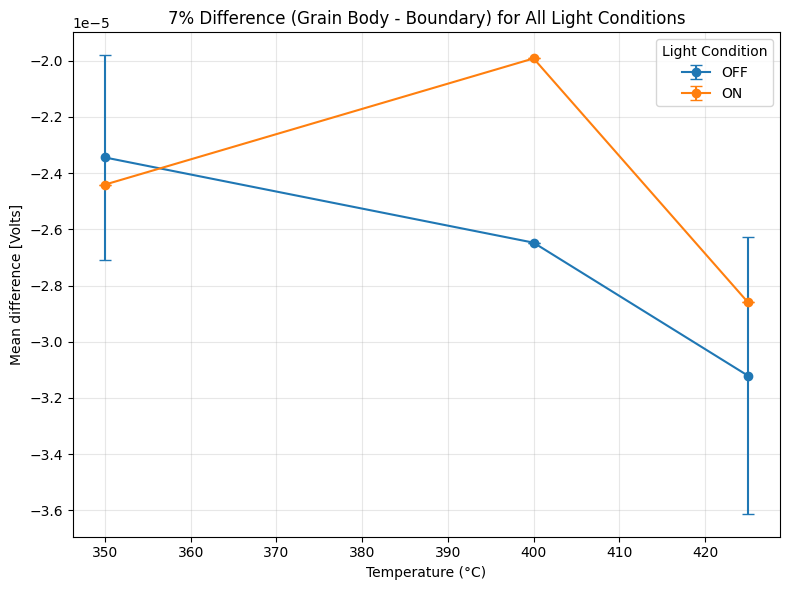

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Compare 7% only: plot difference of means (label 1 - label 2)
pct = 7
sub7 = agg[agg['percentage'] == pct].copy()
if sub7.empty:
    print('No data for 7%')
else:
    # Pivot and compute difference
    pivot = sub7.pivot_table(
        index=['temperature', 'light_condition'],
        columns='label',
        values=['mean_of_mean', 'std_of_mean']
    )
    pivot.columns = ['{}_{}'.format(stat, int(lbl)) for stat, lbl in pivot.columns]
    pivot = pivot.reset_index()
    pivot['diff_mean_1_2'] = pivot.get('mean_of_mean_1', np.nan) - pivot.get('mean_of_mean_2', np.nan)
    pivot['diff_std'] = np.sqrt(
        pivot.get('std_of_mean_1', 0).fillna(0)**2 + pivot.get('std_of_mean_2', 0).fillna(0)**2
    )

    # Display for inspection
    display(pivot)

    # Plot all light conditions in one figure
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.tab10.colors  # distinct color set

    for i, light in enumerate(pivot['light_condition'].unique()):
        d = pivot[pivot['light_condition'] == light].sort_values('temperature')
        if d.empty:
            continue
        ax.errorbar(
            d['temperature'], d['diff_mean_1_2'],
            yerr=d['diff_std'], fmt='o-', color=colors[i % len(colors)],
            capsize=4, label=f'{light}'
        )

    # Add reference line and labels
    #ax.axhline(0, color='gray', linestyle='--')
    ax.set_title('7% Difference (Grain Body - Boundary) for All Light Conditions')
    ax.set_xlabel('Temperature (°C)')
    ax.set_ylabel('Mean difference [Volts]')
    ax.legend(title='Light Condition')
    ax.grid(alpha=0.3)

    # Center the y-axis limits around 0 for balance
     #y_min, y_max = ax.get_ylim()
      #max_abs = max(abs(y_min), abs(y_max))
    #ax.set_ylim(-max_abs * 1.1, y_max * 0.5)  # 10% padding

    # Save and show
    out_png = OUT_DIR / 'diff_means_7pct_combined.png'
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    print('Saved combined diff plot to:', out_png.resolve())
    plt.show()


Notes:
- The notebook aggregates per-file `mean` values and draws the mean of those means along with the std across files.
- For the 7% condition the notebook computes the difference (label 1 - label 2) and shows propagated std as error bars.
- If you'd like weighted aggregation by `count` or statistical tests added, tell me which test you prefer (e.g., t-test).

In [11]:
import gwyfile
from typing import Optional
import numpy as np

def load_gwy_topography_like_notebook(path: str, channel_name: Optional[str] = None, scale: float = 1e6) -> np.ndarray:
    """Load a .gwy file and return a 2D numpy array (topography)."""
    if gwyfile is None:
        raise RuntimeError("gwyfile is required to load .gwy files (install gwyfile).")

    obj = gwyfile.load(path)
    channels = gwyfile.util.get_datafields(obj)
    if not channels:
        raise ValueError(f"No datafields found in GWY file: {path}")

    if channel_name is None:
        channel_name = list(channels.keys())[0]

    channel = channels[channel_name]
    img = channel.data * scale
    # reshape if flattened data object
    arr = np.asarray(img)
    if arr.ndim == 1 and hasattr(channel, 'yres') and hasattr(channel, 'xres'):
        arr = arr.reshape(channel.yres, channel.xres)

    return arr.astype('float32')


In [12]:
try:
    import cv2
    
    def create_outline_opencv(mask):
        kernel = np.ones((3,3), np.uint8)
        eroded = cv2.erode(mask.astype(np.uint8), kernel, iterations=1)
        outline = mask - eroded
        return outline
        
    outline = create_outline_opencv(mask)
    
except ImportError:
    print("OpenCV not available, using NumPy method")
    outline = create_outline_fast(mask)

NameError: name 'mask' is not defined

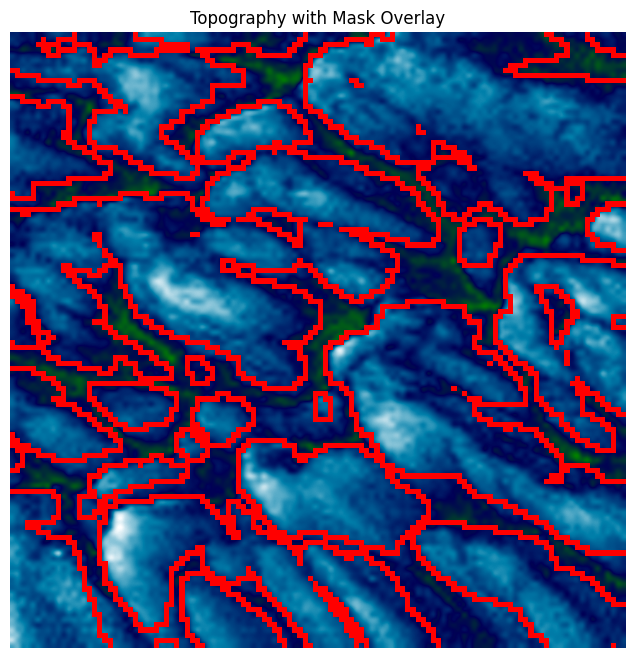

In [13]:
import matplotlib.pyplot as plt
import numpy as np
nn = 13
datafile = f"C:\\Users\\david\\Dropbox\\random_forest_gui\\data_sergio_12.10.25\\CdTe_7per_425C_{nn}.gwy"
maskfile = f"C:\\Users\\david\\Dropbox\\random_forest_gui\\data_sergio_12.10.25\\CdTe_7per_425C_{nn}.npy"
from matplotlib.colors import ListedColormap
# Load your topography data
data = load_gwy_topography_like_notebook(datafile,channel_name="CPD")

# Load your mask (replace with actual path to your .npy file)
mask = np.load(maskfile)
outline = create_outline_opencv(mask)
# Create the plot
plt.figure(figsize=(10, 8))

# Show topography data
plt.imshow(data, cmap='ocean_r', interpolation='spline16')

# Overlay mask with semi-transparency
# Choose a color that contrasts well with grayscale
plt.imshow(outline, cmap=ListedColormap(['none', 'red']), interpolation='none')
# Add colorbars (optional)
#plt.colorbar(label='Topography Height')
# For mask colorbar if needed:
# plt.colorbar(plt.cm.ScalarMappable(cmap='Reds'), label='Mask Value')

plt.title('Topography with Mask Overlay')
plt.axis('off')  # Remove axes if desired
plt.show()

# Surface Photo Voltage


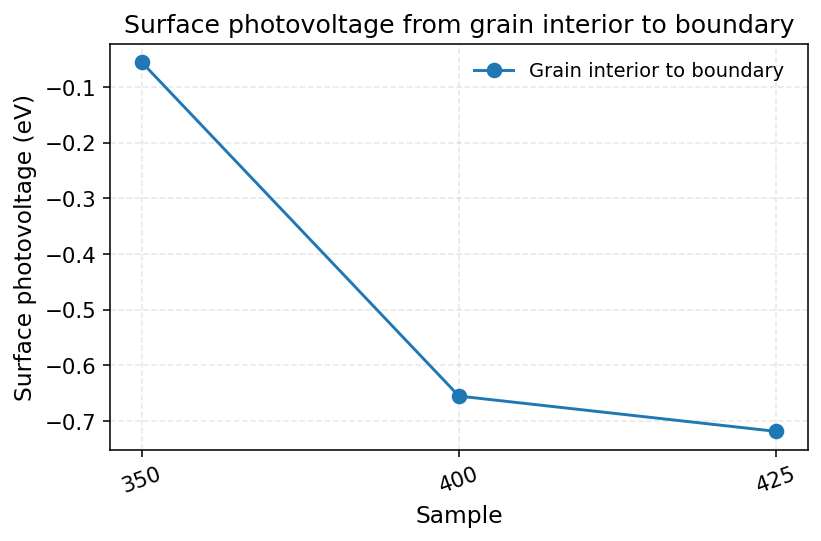

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 1. Load data
# =========================
# Make sure this filename matches your file location
df = pd.read_csv("stats_with_light_condition.csv")

# Expected columns:
# 'Sample'          e.g. CdTe_7per_350C
# 'Label'           1 = grain interior, 2 = grain boundary
# 'Light Condition' 'ON' or 'OFF'
# 'Work Function'   float (eV)

# =========================
# 2. Compute Surface Photo Voltage
#    SPV = WF_ON - WF_OFF
# =========================

df["Surface_photo_voltage"] = np.nan

# group by Sample + Label to get one SPV per region
for (sample, label), g in df.groupby(["temperature", "label"]):
    conds = g["light_condition"].unique()
    if ("ON" in conds) and ("OFF" in conds):
        wf_off = g.loc[g["light_condition"] == "OFF", "mean"].iloc[0]
        wf_on  = g.loc[g["light_condition"] == "ON",  "mean"].iloc[0]
        spv = wf_on - wf_off

        # assign the same SPV to both ON and OFF rows for that (Sample, Label)
        mask = (df["temperature"] == sample) & (df["label"] == label)
        df.loc[mask, "Surface_photo_voltage"] = spv

# Optionally save the updated table
df.to_csv("stats_with_light_condition_with_SPV.csv", index=False)

# =========================
# 3. Plot SPV by sample for
#    grain interior (1) and
#    grain boundary (2)
# =========================

# We only need one row per Sample+Label for plotting; use the ON rows
df_on = df[df["light_condition"] == "ON"].copy()

# sort samples for nicer x-axis
samples = sorted(df_on["temperature"].unique())
x = np.arange(len(samples))

# collect SPV for each label
spv_label1 = []
spv_label2 = []

for s in samples:
    # grain interior (Label 1)
    spv1 = df_on.loc[(df_on["temperature"] == s) & (df_on["label"] == 1),
                     "Surface_photo_voltage"]
    spv_label1.append(spv1.iloc[0] if not spv1.empty else np.nan)

    # grain boundary (Label 2)
    spv2 = df_on.loc[(df_on["temperature"] == s) & (df_on["label"] == 2),
                     "Surface_photo_voltage"]
    spv_label2.append(spv2.iloc[0] if not spv2.empty else np.nan)

scale = 1e5  # convert eV to meV
spv_label1 = np.array(spv_label1, dtype=float)
spv_label2 = np.array(spv_label2, dtype=float)
spv_label3 = np.array(spv_label2 - spv_label1, dtype=float)*scale
# =========================
# 4. Nice-looking plot
# =========================

plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.dpi": 140
})

fig, ax = plt.subplots(figsize=(6, 4))
ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
offset = 0
ms = 7
lw = 1.5

#ax.plot(x - offset, spv_label1, "o-", lw=lw, ms=ms,
#        label="Grain interior ")
#ax.plot(x + offset, spv_label2, "s--", lw=lw, ms=ms,
#        label="Grain boundary ")
ax.plot(x - offset, spv_label3, "o-", lw=lw, ms=ms,
        label="Grain interior to boundary ")
#ax.axhline(0, color="grey", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(samples, rotation=20)
ax.set_ylabel("Surface photovoltage (eV)")
ax.set_xlabel("Sample")

ax.set_title("Surface photovoltage from grain interior to boundary")
ax.grid(alpha=0.3, linestyle="--")
ax.legend(frameon=False)
fig.tight_layout()
plt.show()


In [61]:
spv_label1-spv_label2

array([5.59612090e-06, 6.55489566e-05, 7.18883530e-05])

In [62]:
spv_label3

array([-5.59612090e-05, -6.55489566e-04, -7.18883530e-04])